<a href="https://colab.research.google.com/github/stephenkiilu/Geometric-deep-learning-GDL/blob/main/Stephen_Kiilu_Group_Convolutional_Networks_AMMI_Geometric_Deep_Learning_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDL100 Practical 2: Group Equivariant Neural Networks
---

Notebook written by *Gabriele Cesa* (cesa.gabriele@gmail.com)


**Name: Stephen Kiilu**

**Course: GDL Lab2**


---

During the lectures, you have learnt that the symmetries of a machine learning task can be modelled with **groups**.

For example, an image classification task has a *rotational* symmetry if the label/class of an image does not depend on the orientation of the image, i.e. it is invariant to rotations of the image.
This symmetry is modelled by the group $SO(2)$, i.e. the group of all planar rotations.

When a task is symmetric with respect to a group $G$, it is usually beneficial to leverage this prior knowledge by designing our neural network to be **equivariant** to $G$.

In this assignment, you will first test your understanding of some concepts from *Group Theory*.
Next, you will use these concepts to build a group-convolution layer and, therefore, a group-convolutional network.
You will evaluate your models on the MNIST rot dataset.


## Instructions

Instructions:
- Make a copy of this notebook and add your name to the title.
- Fill in your code solutions between `### BEGIN SOLUTION` and `### END SOLUTION` and your answers to the open-ended questions where you see `YOUR ANSWER`. Do not create additional cells.
- Your code should run without errors in Google Colab.
- For you solution to be correct, you should achieve at least the task accuracy as stated in the tasks (although some unlucky seeds may give you slightly lower accuracy).
- Any questions that may arise can be directed to your TA or asked on Campuswire.
- This homework has a total of 100 points but includes an additional (harder) bonus question which can give you up to 15 additional points (for a total of 115 points).
This question is not necessary to obtain a full grade for this assignment but can give you some additional points which are going to be taken into account in the final grade.
- You should hand in a link to a Google Colab notebook containing your solutions.

Good luck!

Before starting, let's install a few useful packages.
In this homework, we will mostly need **numpy** and **pytorch**.

In [5]:
!pip install torch torchvision numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# 1. Group Theory

First of all, let's review some Group Theory.

Recall the defintion of a **group**:



> **Definition**: *Group* \\
 A group $(G, \cdot)$ is a set $G$ together with a binary operation (the *group law*) $\cdot : G \times G \to G$ which satisfies the following axioms:
*   *Associativity*:  $\forall a, b, c \in G \quad a \cdot (b \cdot c) = (a \cdot b) \cdot c$
*   *Identity*:  $\exists e \in G : \forall g \in G \quad g \cdot e = e \cdot g = g$
*   *Inverse*:   $\forall g \in G \ \ \exists g^{-1} \in G: \quad g g^{-1} = g^{-1} g = e$

To simplify the notation, it is common to use $G$ also to refer to the group instead of just the set of its elements.

Note that a group is *not* necessarily commutative, i.e. $a \cdot b \neq b \cdot a$ generally.
A group with commutative operations is called an **abelian** group.

Useful property: $(a \cdot b)^{-1} = b^{-1} \cdot a^{-1}$.


### 1.1 Exercise: Prove Uniqueness of the Inverse     (5pt)
Given a group $G$, for any element $a \in G$, there exists a unique element $b \in G$ such that $a \cdot b = b \cdot a = e$, where $e$ is the identity.
We usually indicate the inverse of $a$ with $a^{-1}$.
In this exercise, you will prove this property.

To do so, show that if $a, b, c \in G$ and $a \cdot b = b \cdot a = e$ and $a \cdot c = c \cdot a = e$, then $b = c$.


#### 1.1 Insert Your Solution Here:

Suppose that:
$$
\exists a, b, c \in G: a \circ b=b \circ a=e, a \circ c=c \circ a=e
$$
that is, that $b$ and $c$ are both inverse elements of $a$.

Then:
$$
\begin{aligned}
b &=b \circ e & & \text { as } e \text { is the identity element } \\
&=b \circ(a \circ c) & & \text { as } c \text { is an inverse of } a \\
&=(b \circ a) \circ c & & \text {associativity } \\
&=e \circ c & & \text { as } b \text { is an inverse of } a \\
&=c & & \text { as } e \text { is the identity element }
\end{aligned}
$$
So $b=c$ and hence the result.






### 1.2 Exercise: Implement the Group $C_4$ (5pt)

Consider the group $G$ of rotations by multiples of $\frac{\pi}{2}$.
This group contains $4$ elements and is called the **cyclic group** of order $4$; we usually indicate it with $G=C_4$:
$$
  C_4 = \{R_{0}, R_{\frac{\pi}{2}}, R_{\pi}, R_{3\frac{\pi}{2}} \} = \{ R_{r \frac{\pi}{2}} \ |\ r = 0, 1, 2, 3\}
$$
Note that we can identify the elements of $C_4$ with $\mathbb{Z} / 4\mathbb{Z}$, i.e. the integers *modulo* $4$; indeed:
$$
  R_{r \frac{\pi}{2}} \cdot R_{s \frac{\pi}{2}} = R_{(r + s \mod 4) \frac{\pi}{2}}
$$

To simplify the notation, we will sometimes just write $r$ instead of $R_{r \frac{\pi}{2}}$.

In this execise, you will implement the operations of the group $C_4$.
Fill blocks in the following template:

In [2]:
class C4:
 
  @staticmethod
  def product(r: int, s: int) -> int:
    # Implements the *group law* of the group C_4.
    # The input `r` and `s` must be integers in {0, 1, 2, 3} and represent two elements of the group.
    # The method should return the integer representing the product of the two input elements.
    # You should also check that the inputs are valid.

    ### BEGIN SOLUTION
    assert r in {0,1,2,3}, 'must be integers in {0, 1, 2, 3}'
    assert s in {0,1,2,3}, 'must be integers in {0, 1, 2, 3}'

    return (r+s) % 4

    ### END SOLUTION
  
  @staticmethod
  def inverse(r: int) -> int:
    # Implements the *inverse* operation of the group C_4.
    # The input `r` must be an integer in {0, 1, 2, 3} and represents an element of the group.
    # The method should return the integer representing the inverse of input element.
    # You should also check that the input is valid.

    ### BEGIN SOLUTION
    assert r in {0,1,2,3}, 'must be integers in {0, 1, 2, 3}'
    return (4-r) % 4
    ### END SOLUTION




In [3]:
# Some test cases to check if your implementation is working
assert C4.product(1, 3) == 0
assert C4.product(0, 0) == 0
assert C4.product(2, 3) == 1
assert C4.inverse(0) == 0
assert C4.inverse(1) == 3

### 1.3 Exercise: Implement the Group $D_4$ (8pt)
Let's now consider the more complex group of $4$ rotations *and* reflections.
The **dihedral group** $D_4$ contains the $4$ rotations by multiples of $\frac{\pi}{2}$ and $4$ reflections along the $4$ different symmetry axes of a square:
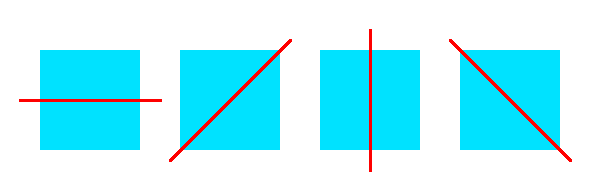

In total, $D_4$ contains $8$ elements:
$$
  D_4 = \{R_{0}, R_{\frac{\pi}{2}}, R_{\pi}, R_{3\frac{\pi}{2}}, F, R_{\frac{\pi}{2}} \cdot F, R_{\pi} \cdot F,  R_{3\frac{\pi}{2}}  \cdot F \}
$$
The first four elements are the elements of $C_4$.
The other four are obtained by first applying a reflection $F$ along the *horizontal axis* and then rotating by a multiple of $\frac{\pi}{2}$ .
You can verify that all the four reflection in the image above can indeed be obtained this way.

This means that we can identify an element $g \in D_4$ of this group a pair $(f, r)$, where $r = 0, 1, 2, 3$ indicates the rotation while $f = 0, 1$ indicates whether we apply a reflection or not.

In this execise, you will implement the operations of the group $D_4$.
This time, however, you will also need to finish deriving the group law.
To do so, you need to know:
*   two reflections give an identity, i.e. $F \cdot F = R_0$
*   a reflection inverts a rotation, i.e. $F \cdot R_{r \frac{\pi}{2}} = R_{r \frac{\pi}{2}}^{-1} \cdot F$

Now, using the other properties of the group law (recall the definition at the beginning of this notebook), you can write the product between any pair of elements $a, b$ of $D_4$.
Once you have found the right group law, you will implement it in Python.
Fill the blocks in the following template:

**Properties of group**

In general, the group $D_{n}$ has elements $r_{0}, \ldots, r_{n-1}$ and $s_{0}, \ldots, s_{n-1}$, with composition given by the following formulae:
$$
\mathrm{r}_{i} \mathrm{r}_{j}=\mathrm{r}_{i+j}, \quad \mathrm{r}_{i} \mathrm{~s}_{j}=\mathrm{s}_{i+j}, \quad \mathbf{s}_{i} \mathrm{r}_{j}=\mathbf{s}_{i-j}, \quad \mathbf{s}_{i} \mathbf{s}_{j}=\mathrm{r}_{i-j} .
$$

In our case $n=4$ and we have $D_4$. This will be implemented below.

In [4]:
class D4:

  @staticmethod
  def product(a: tuple, b: tuple) -> tuple:
    # Implements the *group law* of the group D_4.
    # The input `a` and `b` must be tuples containing two integers, e.g. `a = (f, r)`.
    # The two integers indicate whether the group element includes a reflection and the number of rotations.
    # The method should return the tuple representing the product of the two input elements.
    # You should also check that the inputs are valid.

    ### BEGIN SOLUTION
    assert a in {(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)}, 'a must be a tuple of form (f,r)'
    assert b in {(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)}, 'a must be b tuple of form (f,r)'

    if a[0] == 0 and b[0] == 0:
      return (0, (a[1] + b[1])%4)
    if a[0] == 0 and b[0] == 1:
      return (b[0], 4-abs(a[1]- b[1]))
    if a[0] == 1 and b[0] == 0:
      return (a[0], (a[1] + b[1])%4)
    if a[0] == 1 and b[0] == 1:
      return (0, abs(b[1]- a[1]))

    ### END SOLUTION
  
  @staticmethod
  def inverse(g: int) -> int:
    # Implements the *inverse* operation of the group D_4.
    # The input `g` must be a tuple containing two integers, e.g. `g = (f, r)`.
    # The two integeres indicate whether the group element includes a reflection and the number of rotations.
    # The method should return the tuple representing the inverse of the input element.
    # You should also check that the input is valid.

    ### BEGIN SOLUTION
    assert g in {(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)}
    if g[0] == 0:
        return (0,(4 - g[1])%4)
    else:
        return (1,((8-g[1] )%4))

    ### END SOLUTION




Let's check if the implementation works!

You should play with these operations using other inputs and make sure the outputs you find match your expectations

In [5]:
e = (0, 0) # the identity element
f = (1, 0) # the horizontal reflection
r = (0, 1) # the rotation by 90 degrees

# Let's verify that the implementation is consistent with the instructions given
assert D4.product(e, e) == e
assert D4.product(f, f) == e
assert D4.product(f, r) == D4.product(D4.inverse(r), f)

# Let's verify that the implementation satisfies the group axioms
a = (1, 2)
b = (0, 3)
c = (1, 1)
assert D4.product(a, e) == a
assert D4.product(e, a) == a
assert D4.product(b, D4.inverse(b)) == e
assert D4.product(D4.inverse(b), b) == e

assert D4.product(D4.product(a, b), c) == D4.product(a, D4.product(b, c))

We now introduce a new defintion:

> **Definition**: *Group Action* \\
Let $G$ be a group. A **$G$-space** $X$ is a set $X$ equipped with a *group action* $. : G \times X \to X,\ (g, x) \mapsto g.x$ which satisfies the following axioms:
*   *Identity*: $\forall x \in X \quad e.x = x$ 
*   *Compatibility*: $\forall a, b \in G \ \forall x \in X \quad a.(b.x) = (a \cdot b).x$ 

We say that $G$ *acts on* $X$.

Let's see an example.
Consider again the group $G=C_4$ of planar rotations by multiples of $\frac{\pi}{2}$.
Let $X$ be the set of all $33 \times 33$ gray-scale images.
An image $x \in X$ is interpreted as a function $x: \mathbf{p} \mapsto x[\mathbf{p}] \in \mathbb{R}$ which maps each pixel (identified by its coordinates $\mathbf{p} = (h,w)$) to a real number.

An element $g = R_{r \frac{\pi}{2}} \in G$ transforms an image $x \in X$ into the image $g.x \in X$ through a counter-clockwise rotation by $r \frac{\pi}{2}$ radians.
The rotated image $g.x$ is defined on each pixel $\mathbf{p}$ as:
$$
 [g.x](\mathbf{p}) := x(g^{-1}.\mathbf{p})
$$
where $g^{-1}.\mathbf{p}$ is the pixel in the original image $x$ which is moved to the position $\mathbf{p}$ in the new image $g.x$.

This action can be easily implemented with **PyTorch**:


In [6]:
def rotate(x: torch.Tensor, r: int) -> torch.Tensor:
  # Method which implements the action of the group element `g` indexed by `r` on the input image `x`.
  # The method returns the image `g.x`
  
  # note that we rotate the last 2 dimensions of the input, since we want to later use this method to rotate minibatches containing multiple images
  return x.rot90(r, dims=(-2, -1))


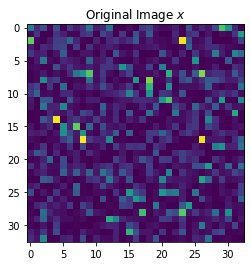

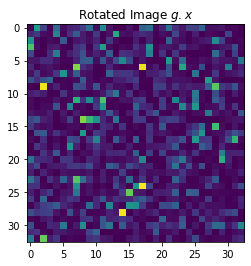

In [7]:
x = torch.randn(1, 1, 33, 33)**2

r = 1
gx = rotate(x, r)

plt.imshow(x[0, 0].numpy())
plt.title('Original Image $x$')
plt.show()

plt.imshow(gx[0, 0].numpy())
plt.title('Rotated Image $g.x$')
plt.show()

# 2. Equivariant Convolution Layers

Let's try now to build a rotation equivariant convolution layer.
An equivariant layer is a function $\psi: X \to Y$ from an input $G$-space $X$ to an output $G$-space $Y$.
We assume the input space is the space of images we defined before but we still need to choose an output space $Y$.
As a first example, we choose $Y = X$, i.e. the output is still a space of grayscale images.

Our equivariant layer will be a convolution with a $3 \times 3$ filter.
Note that the use of convolution guarantees the translation equivariance.
Unfortunately, this is not sufficient for guaranteeing rotation equivariance.
Let's verify this:

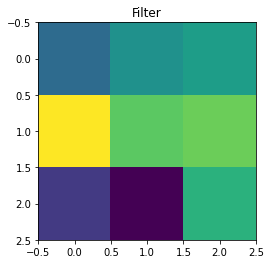

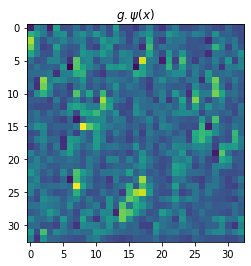

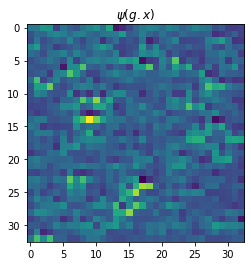

In [8]:
filter3x3 = torch.randn(1, 1, 3, 3)

plt.imshow(filter3x3[0, 0].numpy())
plt.title('Filter')
plt.show()


psi_x = torch.conv2d(x, filter3x3, bias=None, padding=1)
psi_gx = torch.conv2d(gx, filter3x3, bias=None, padding=1)

g_psi_x = rotate(psi_x, r)

plt.imshow(g_psi_x[0, 0].numpy())
plt.title('$g.\psi(x)$')
plt.show()

plt.imshow(psi_gx[0, 0].numpy())
plt.title('$\psi(g.x)$')
plt.show()

Clearly, the two images do not look the same!

To ensure that both outputs are the same, we need to constrain the convolutional filter to be symmetric to rotations, i.e. to be an isotropic filter:

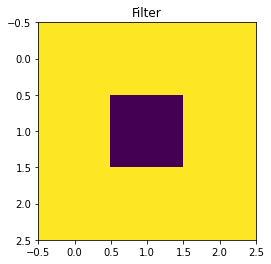

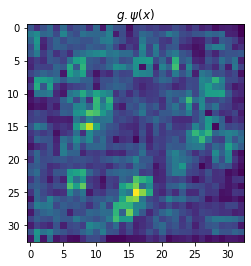

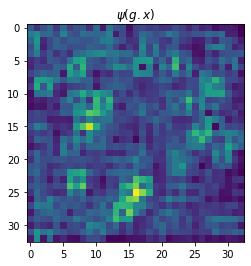

In [9]:
filter3x3 = torch.empty((1, 1, 3, 3))
# fill the central pixel
filter3x3[0, 0, 1, 1] = np.random.randn()
# fill the ring of radius 1 around it with a unique value
mask = torch.ones(3, 3, dtype=torch.bool)
mask[1, 1] = 0
filter3x3[0, 0, mask] = np.random.randn()

plt.imshow(filter3x3[0, 0].numpy())
plt.title('Filter')
plt.show()


psi_x = torch.conv2d(x, filter3x3, bias=None, padding=1)
psi_gx = torch.conv2d(gx, filter3x3, bias=None, padding=1)

g_psi_x = rotate(psi_x, r)

plt.imshow(g_psi_x[0, 0].numpy())
plt.title('$g.\psi(x)$')
plt.show()

plt.imshow(psi_gx[0, 0].numpy())
plt.title('$\psi(g.x)$')
plt.show()

assert torch.allclose(psi_gx, g_psi_x, atol=1e-6, rtol=1e-6)

The two outputs are now equivalent!

### 2.1 Exercise: Implement a Rotation Equivariant Convolution layer with Isotropic Filters (12 pt)

We use this idea as a building block for our neural network.
In this exercise, you will implement a `torch.nn.Module` which performs convolution with a learnable set of isotropic filters.
Fill the blocks in the following template:

In [10]:
class IsotropicConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, bias: bool = True):
    
    super(IsotropicConv2d, self).__init__()

    self.kernel_size = 3
    self.stride = 1
    self.dilation = 1
    self.padding = 1
    
    # In this block you need to create a tensor which stores the learnable weights
    # Recall that each 3x3 filter has only `2` learnable parameters, one for the center and one for the ring around it.
    # In total, there are `in_channels * out_channels` different filters.
    # Remember to wrap the weights tensor into a `torch.nn.Parameter` and set `requires_grad = True`

    # initialize the weights with some random values from a normal distribution with std = 1 / sqrt(out_channels * in_channels)

    self.weight = None

    ### BEGIN SOLUTION

    self.weight=torch.nn.Parameter(torch.empty(out_channels,in_channels,2).normal_(mean=0,std= 1/np.sqrt(out_channels * in_channels)),requires_grad=True)

    ### END SOLUTION

    if bias:
      self.bias = torch.nn.Parameter(torch.zeros(out_channels), requires_grad=True)
    else:
      self.bias = None
  
  def build_filter(self) ->torch.Tensor:
    # using the tensor of learnable parameters, build the `out_channels x in_channels x 3 x 3` filter
    
    # Make sure that the tensor `filter3x3` is on the same device of `self.weight`
    
    filter3x3 = None

    ### BEGIN SOLUTION
    ## our filter
    filter3x3 = torch.empty((self.weight.shape[0], self.weight.shape[1], 3, 3)).to(self.weight.device)

    # fill the central pixel
    filter3x3[:, :, 1, 1] = self.weight[:,:,0]

    # fill the ring of radius 1 around it with a unique value
    mask = torch.ones(3, 3, dtype=torch.bool)
    mask[1, 1] = 0
    filter3x3[:, :, mask] = self.weight[:,:,1].unsqueeze(-1)

    ### END SOLUTION

    return filter3x3

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter = self.build_filter()

    return  torch.conv2d(x, _filter,
                            stride=self.stride,
                            padding=self.padding,
                            dilation=self.dilation,
                            bias=self.bias)



In [11]:
# Let's check if the layer is really equivariant

in_channels = 5
out_channels = 10
batchsize = 6
S = 33

layer = IsotropicConv2d(in_channels=in_channels, out_channels=out_channels, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, S, S)
gx = rotate(x, 1)


psi_x = layer(x)
psi_gx = layer(gx)

g_psi_x = rotate(psi_x, 1)

assert psi_x.shape == g_psi_x.shape
assert psi_x.shape == (batchsize, out_channels, S, S)

# check the model is giving meaningful outputs
assert not torch.allclose(psi_x, torch.zeros_like(psi_x), atol=1e-4, rtol=1e-4)

# check equivariance
assert torch.allclose(psi_gx, g_psi_x, atol=1e-6, rtol=1e-6)

# check the model has the right number of parameters
assert layer.weight.numel() == in_channels * out_channels * 2

Unfortunately, isotropic filters are not very expressive.
Instead, we would like to use more general, unconstrained filters.
To do so, we need to rely on **group convolution**.



Group convolution is a generalization of the convolution operation over a group.
The key idea is that of transforming a filter with a larger set of transformations, rather than just translations.
In this homework, the transformations we consider will include both translations and rotations.

Note: we will use the word *convolution* to be consistent with the deep learning literature, even if we technically are using a *cross-correlation*.

Before defining group convolution, we need to introduce another group.

---

### The rotations and translations group

$p4$ is the *Wallpaper group*, i.e. the group of translations and rotations by multiples of $\frac{\pi}{2}$ of a grid.

An element of this group is identified by a tuple $(h, w, r)$, where $h, w \in \mathbb{Z}$ are integer translations and $r \in C_4$ is a rotation.
To reduce the notation, we write $(\mathbf{t}, r)$ with $\mathbf{t} = (h, w)$, instead of $(h, w, r)$.

The element $(\mathbf{t}, r)$ acts on a point $\mathbf{p} \in \mathbb{Z}^2$ on the grid by first rotating the point with $r \in C_4$ and then translating it with $\mathbf{t}$, i.e. $(\mathbf{t}, r).\mathbf{p} = \mathbf{t} + r.\mathbf{p}$.
The composition of two elements $(\mathbf{t}, r)$ and $(\mathbf{p}, s)$ is $(\mathbf{t}, r) \cdot (\mathbf{p}, s) = (\mathbf{t} + r.\mathbf{p}, r\cdot s)$.
Finally, the inverse of $(\mathbf{t}, r)$ is $(r^{-1}.-\mathbf{t}, r^{-1})$.
You should try to verify on paper that these rules are consistent with the group axioms in the definition of group given above.

---

### Group Convolution

Let $X$ be again the space of grayscale images on a grid.
Let now $\psi \in X$ be a filter and $x \in X$ an input image.
The group convolution of $\psi \star x$ is defined as:
$$
  [\psi \star x](\mathbf{t}, r) := \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} \mathbf{p})\ x(\mathbf{p})
                                 = \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi(r^{-1} (\mathbf{p} - \mathbf{t}))\ x(\mathbf{p})
$$
Note: the output of the convolution is not anymore a grayscale image in $X$.
It is now a function over the group $p4$ we considered; indeed, we store an output value for each different transformation $(\mathbf{t}, r)$ we applied to the filter $\phi$.

Let's call the space of all output signals $Y$.
This is the space of all functions on the group $p4$, i.e. $Y$ is the space of all functions $y: p4 \to \mathbb{R}$.
$Y$ is a $G$-space with a natural action of $p4$ on it:
$$
  [(\mathbf{t}, r).y](\mathbf{p}, s) := y((\mathbf{t}, r)^{-1} \cdot (\mathbf{p}, s)) = y(r^{-1}(\mathbf{p} - \mathbf{t}), r^{-1}s)
$$

In other words, the use of a general filter $\psi$ (i.e. non isotropic) in a group convolution maps the input space of images $X$ into a new larger space $Y$.
This operation is sometimes also called a **lifting convolution** since it maps the space $X$ to the more complex space $Y$.
Note that a function $y \in Y$ can be implemented as a $4$-channels image, where the $i$-th channel ($i = 0, 1, 2, 3$) is defined as $y_i(\mathbf{t}) = y(\mathbf{t}, r=i) \in \mathbb{R}$.



### 2.2 Implement the Group Action on the space of functions over $p4$   (5pt)

In this exercise, you will need to implement the action of a rotation $r \in C_4$ on a function $y \in Y$.
In other words, you need to implement a function which takes $y$ in input and returns $r.y$, which is defined at each pixel $\mathbf{p}$ as
$$
  [r.y](\mathbf{p}, s) := y(r^{-1} (\mathbf{p}, s)) = y(r^{-1}\mathbf{p}, r^{-1}s)
$$

HINT: you can reuse the function `rotate` defined earlier to rotate the pixels' location; then, you will need to permute the $4$ channels at each pixel depending on $r$.
Fill the block in the following template:

In [12]:
def rotate_p4(y: torch.Tensor, r: int) -> torch.Tensor:
  # `y` is a function over p4, i.e. over the pixel positions and over the elements of the group C_4.
  # This method implements the action of a rotation `r` on `y`.
  # To be able to reuse this function later with a minibatch of inputs, assume that the last two dimensions (`dim=-2` and `dim=-1`) of `y` are the spatial dimensions
  # while `dim=-3` has size `4` and is the C_4 dimension.
  # All other dimensions are considered batch dimensions
  assert len(y.shape) >= 3
  assert y.shape[-3] == 4

  ### BEGIN SOLUTION
  shifts=torch.roll(y,r,-3)
  return rotate(shifts,r)


  
  ### END SOLUTION

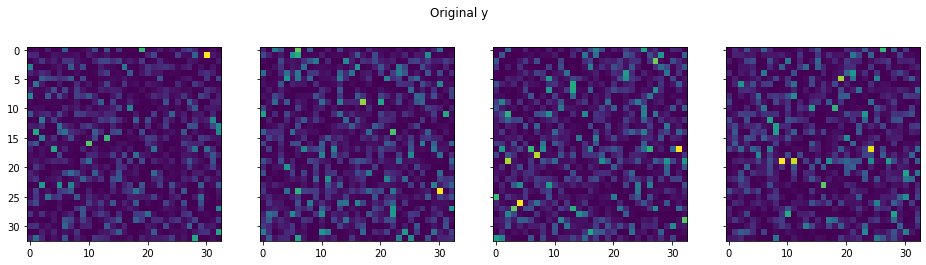

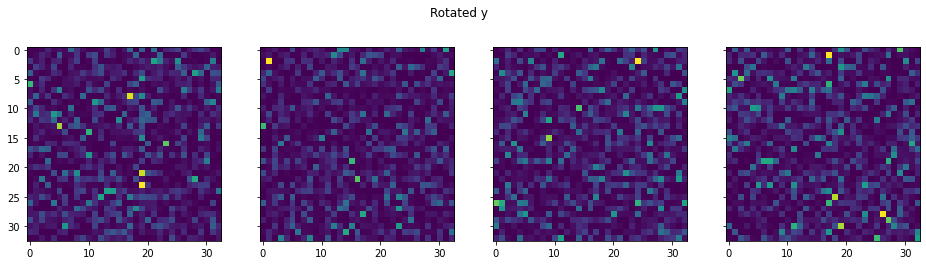

In [13]:
# Let's test a rotation by r=1

y = torch.randn(1, 1, 4, 33, 33)**2


ry = rotate_p4(y, 1)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(y[0, 0, i].numpy())
fig.suptitle('Original y')
plt.show()

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(ry[0, 0, i].numpy())
fig.suptitle('Rotated y')
plt.show()


# check that the images are actually rotated:
for _ in range(10):
  p = np.random.randint(0, 33, size=2)
  s = np.random.randint(0, 4)

  # compute r^-1 s
  _rs = C4.product(C4.inverse(1), s)
  
  # compute r^-1 p
  # note that the rotation is around the central pixel (16, 16)
  # A rotation by r^-1 = -90 degrees maps (X, Y) -> (Y, -X)
  center = np.array([16, 16])
  # center the point
  centered_p = p - center
  # rotate round the center
  rotated_p = np.array([centered_p[1], -centered_p[0]])
  # shift the point back
  _rp = rotated_p + center

  # Finally check that [r.y](p, s) = y(r^-1 p, r^-1 s)

  # However, in a machine, an image is stored with the coordinates (H-1-Y, X) rather than the usual (X, Y), where H is the height of the image;
  # we need to take this into account
  assert torch.isclose(
      ry[..., s, 32-p[1], p[0]],
      y[..., _rs, 32-_rp[1], _rp[0]],
      atol=1e-5, rtol=1e-5
    )




### 2.3 Implement Lifting Convolution (15 pt)

In this exercise, you will build a `PyTorch` module which implements the *lifting convolution* described earlier.
The input of this layer is a grayscale image $x \in X$ (potentially a batch and with more channels).
The output is a function $y \in Y$ (again, potentially many of them by using multiple channels and mini-batches).
For each input channel and output channel, the layer should perform a *lifting convolution* with a learnable filter.

This can be realized by exploiting the usual `torch.conv2d` but by using $4$ rotated copies of a single learnable filter.
To clarify this, observe the image below.
The image shows an input image (containing a green lizard) and $4$ rotated copies of a filter (the small discs).
The image is convolved with each copy independently to generate $4$ different output images, one for each rotation.
Therefore, we can implement this operation by stacking the $4$ copies into a unique filter with $4$ output channels and using this new filter in `torch.conv2d`.

The image also shows that a rotation of the input image results in each of the $4$ output images to rotate independently but also in the cyclic permutation of the $4$ images (look at the highlighted point in the top right image and where it moves to in the second row). 


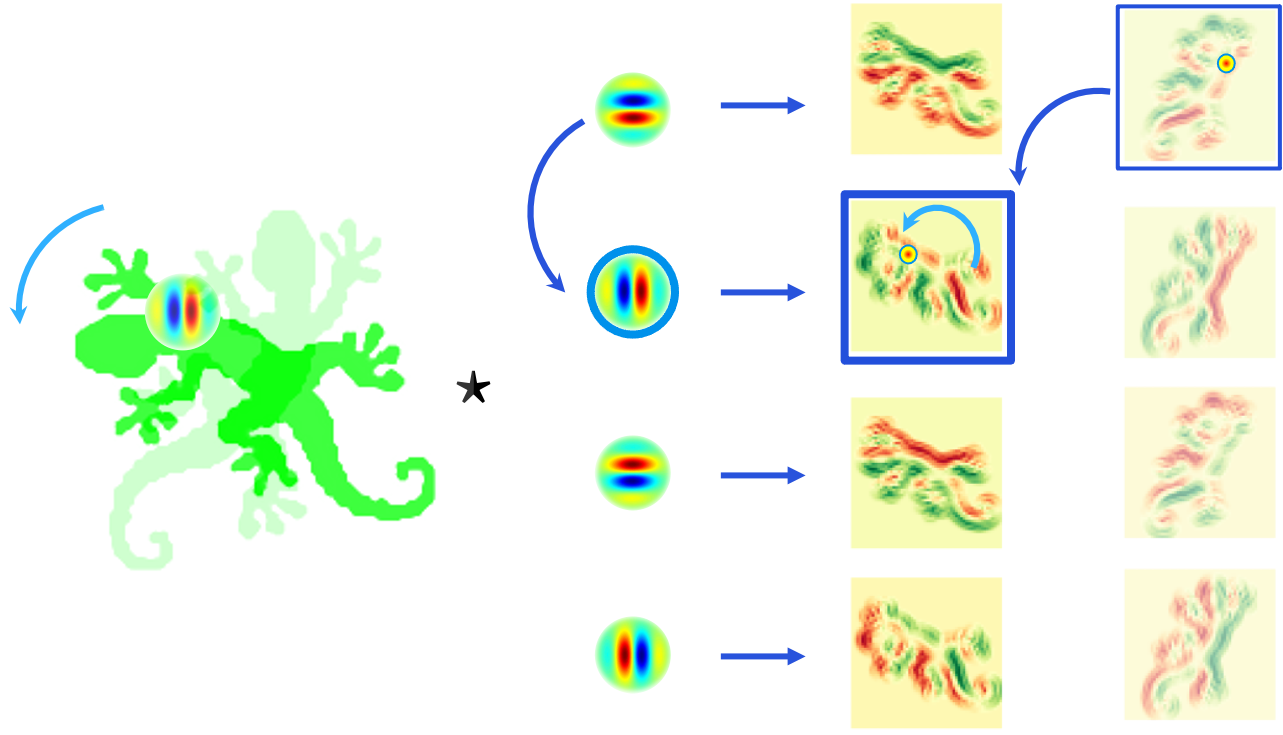

Finally, a convolutional layer usually includes a bias term.
In a normal convolutional network, it is common to share the same bias over all pixels, i.e. the same bias is summed to the features at each pixel.
Similarly, when we use a lifting convolution, we share the bias over all pixels but *also* over all rotations, i.e. over the $4$ output channels.



Implement a *lifting convolution* by filling the blocks in the following template:

In [14]:
class LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(LiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    
    # In this block you need to create a tensor which stores the learnable filters
    # Recall that this layer should have `out_channels x in_channels` different learnable filters, each of shape `kernel_size x kernel_size`
    # During the forward pass, you will build the bigger filter of shape `out_channels x 4 x in_channels x kernel_size x kernel_size` by rotating 4 times 
    # the learnable filters in `self.weight`
    
    # initialize the weights with some random values from a normal distribution with std = 1 / sqrt(out_channels * in_channels)

    self.weight = None

    ### BEGIN SOLUTION

    self.weight=torch.nn.Parameter(torch.empty(self.out_channels,self.in_channels,self.kernel_size,self.kernel_size).normal_(mean=0,
    std= 1/np.sqrt(self.out_channels * self.in_channels)),requires_grad=True)
    
    
    ### END SOLUTION

    # This time, you also need to build the bias
    # The bias is shared over the 4 rotations
    # In total, the bias has `out_channels` learnable parameters, one for each independent output
    # In the forward pass, you need to convert this bias into an "expanded" bias by repeating each entry `4` times
    
    self.bias = None
    # if bias:
    ### BEGIN SOLUTION
    if bias:
      self.bias = torch.nn.Parameter(torch.zeros(self.out_channels), requires_grad=True)
  
    ### END SOLUTION  
  
  def build_filter(self) ->torch.Tensor:
    # using the tensors of learnable parameters, build 
    # - the `out_channels x 4 x in_channels x kernel_size x kernel_size` filter
    # - the `out_channels x 4` bias
    
    _filter = None
    _bias = None

    # Make sure that the filter and the bias tensors are on the same device of `self.weight` and `self.bias`

    # First build the filter
    # Recall that `_filter[:, i, :, :, :]` should contain the learnable filter rotated `i` times

    ### BEGIN SOLUTION

    _filter=torch.empty(self.out_channels,4,self.in_channels,kernel_size, kernel_size).to(self.weight.device)

    for i in range(4):
      _filter[:, i, :, :, :]=rotate(self.weight, i)

    ### END SOLUTION

    # Now build the bias
    # Recall that `_bias[:, i]` should contain a copy of the learnable bias for each `i=0,1,2,3`

    if self.bias is not None:
    ### BEGIN SOLUTION
      _bias=torch.empty(self.out_channels,4).to(self.weight.device)
      for i in range(4):
        _bias[:, i]=self.bias[:]

    ### END SOLUTION
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 4)
    assert _filter.shape == (self.out_channels, 4, self.in_channels, self.kernel_size, self.kernel_size)

    # to be able to use torch.conv2d, we need to reshape the filter and bias to stack together all filters
    _filter = _filter.reshape(self.out_channels * 4, self.in_channels, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 4)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # we need to reshape it to `batch_size x out_channels x 4 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])



In [15]:
# Let's check if the layer is really equivariant

in_channels = 5
out_channels = 10
kernel_size = 3
batchsize = 6
S = 33

layer = LiftingConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, S, S)
# the input image belongs to the space X, so we use the original action to rotate it
gx = rotate(x, 1)

# compute the output
psi_x = layer(x)
psi_gx = layer(gx)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)

assert psi_x.shape == g_psi_x.shape
assert psi_x.shape == (batchsize, out_channels, 4, S, S)

# check the model is giving meaningful outputs
assert not torch.allclose(psi_x, torch.zeros_like(psi_x), atol=1e-4, rtol=1e-4)

# check equivariance
assert torch.allclose(psi_gx, g_psi_x, atol=1e-6, rtol=1e-6)

# check the model has the right number of parameters
assert layer.weight.numel() == in_channels * out_channels * kernel_size**2
assert layer.bias.numel() == out_channels

We just built a rotation equivariant convolutional layer which uses general and expressive filters!

Unfortunately, we are not ready to build a deep convolutional network yet.
Indeed, while the *lifting layer* is equivariant, its output space $Y$ is different from its input space $X$.
This means we cannot directly feed the output of the lifting layer into another lifting layer to build a deep architecture...

To solve this problem, recall the definition of **group convolution**.
If $X$ is space of grayscale images on a grid and $\psi, x \in X$ are respectively the filter and the input image, the group convolution of $\psi \star x$ was defined as:
$$
  [\psi \star x](\mathbf{t}, r) := \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} \mathbf{p})\ x(\mathbf{p})
$$
Note that in this case, both the input $x$ and the filter $\psi$ belong to $X$.
This definition can be adapted to inputs (and therefore filters) which are functions over the elements of the group, i.e. functions in $Y$.

Indeed, a group $G$ has a natural action on the functions over its elements; if $x: G \to \mathbb{R}$ and $g \in G$, the function $g.x$ is defined as:
$$
  [g.x](h) := x(g^{-1} \cdot h)
$$
where $g, h \in G$.

We can use this to build a group convolution with a filter $\psi \in Y$ instead of in $X$.
Let $x, \psi \in Y$ be the input and the filter.
Then $y = \psi \star x$ is defined as:
$$
  [\psi \star x](g) := \sum_{h \in H} \psi(g^{-1} \cdot h)\ x(h)
$$
Note that the output $y =\psi \star x$ still belongs to $Y$, the space of functions over the group $G$.
This means that the group convolution maps $Y$ to $Y$, so we can stack multiple of them to obtain a deep model!

In the case of $G = p4$, the group of translations and rotations, this equation becomes:
$$
  [\psi \star x](\mathbf{t}, r) := \sum_{s \in C_4} \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} (\mathbf{p}, s))\ x(\mathbf{p}, s)
$$
By using the fact that $\psi((\mathbf{t}, r)^{-1} (\mathbf{p}, s)) = \psi(r^{-1} (\mathbf{p} - \mathbf{t}, s)) = [r.\psi](\mathbf{p} - \mathbf{t}, s)$
the equation becomes:
$$
  [\psi \star x](\mathbf{t}, r) := \sum_{s \in C_4} \sum_{\mathbf{p} \in \mathbb{Z}^2} [r.\psi](\mathbf{p} - \mathbf{t}, s)\ x(\mathbf{p}, s)
$$

Note that the term $\sum_{\mathbf{p} \in \mathbb{Z}^2} [r.\psi](\mathbf{p} - \mathbf{t}, s)\ x(\mathbf{p}, s)$ is the usual convolution (`torch.conv2d`) of the grayscale image $x(\cdot, s): \mathbb{Z}^2 \to \mathbb{R}$ with the filter $[r.\psi](\cdot, s): \mathbb{Z}^2 \to \mathbb{R}$, for a fixed value of $s$.
Indeed, the group convolution above can be implemented by using $4 \times 4$  `torch.conv2d` with normal filters.

Look at the following image:

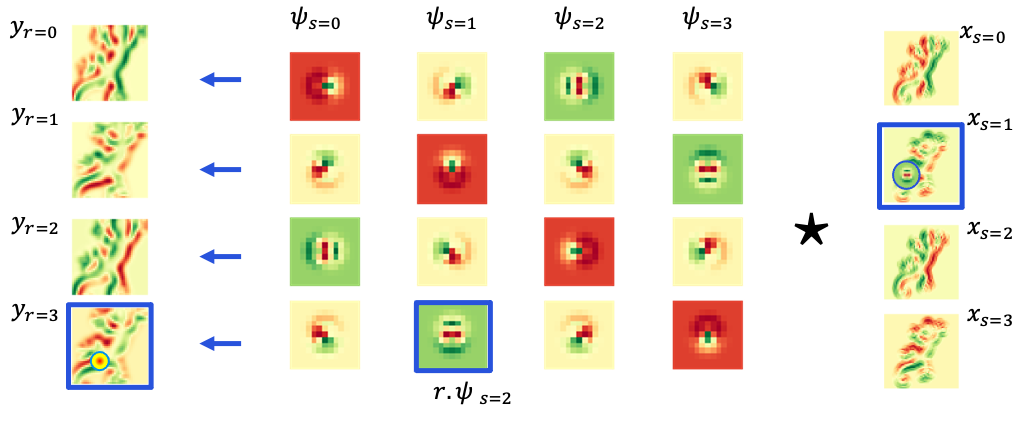

The four images on the right represent the $4$ channels of the input.
Since this is the output of a *lifting layer*, it contains a channel for each rotation $s$.
The $4$ images on the left are the $4$ channels of the output.
Again, there is channel for each rotation $r$.
The $4 \times 4$ grid of images represents the $16$ convolutions.
The filter $\phi \in Y$ also has $4$ channels, one per rotation $s$; these $4$ channels are visualized in the first row of the grid.
For simplicity we used the shorter notation $x_s = x(\cdot, s)$, $\psi_s = \psi(\cdot, s)$ and $y_r = y(\cdot, r)$.

Each other row of the grid contains a copy of the filter $\psi$ (i.e. the first row) rotated by a rotation $r \in C_4$.
A rotation of $\psi$ includes both a rotation of its pixels and a cyclic permutation of the $4$ channels.
In particular, the image highlights the convolution for $r=3$ and $s=1$; the scalar filter $[r.\psi](\cdot, s=1)$ is the highlighted filter $r.\psi_{s=2}$, since it is a rotated copy of $\psi_{s=2} = \psi(\cdot, s=2)$.


### 2.4 Implement A Group-Convolution layer (15 pt)
Now, you should implement this group convolution in a `torch.nn.Module`.
For efficiency, you should rely on `torch.conv2d` as ealier.
Fill the blocks in the following template:

In [16]:
class GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    
    # In this block you need to create a tensor which stores the learnable filters
    # Recall that this layer should have `out_channels x in_channels` different learnable filters, each of shape `4 x kernel_size x kernel_size`
    # During the forward pass, you will build the bigger filter of shape `out_channels x 4 x in_channels x 4 x kernel_size x kernel_size` by rotating 4 times 
    # the learnable filters in `self.weight`
    
    # initialize the weights with some random values from a normal distribution with std = 1 / np.sqrt(out_channels * in_channels)

    self.weight = None

    ### BEGIN SOLUTION

    self.weight=torch.nn.Parameter(torch.empty(self.out_channels,self.in_channels,4,self.kernel_size,self.kernel_size).normal_(mean=0,
    std= 1/np.sqrt(self.out_channels * self.in_channels)),requires_grad=True)
    
    
    ### END SOLUTION

    # The bias is shared over the 4 rotations
    # In total, the bias has `out_channels` learnable parameters, one for each independent output
    # In the forward pass, you need to convert this bias into an "expanded" bias by repeating each entry `4` times
    
    self.bias = None
    if bias:
    ### BEGIN SOLUTION
      self.bias = torch.nn.Parameter(torch.zeros(self.out_channels), requires_grad=True)

    ### END SOLUTION  
  
  def build_filter(self) ->torch.Tensor:
    # using the tensors of learnable parameters, build 
    # - the `out_channels x 4 x in_channels x 4 x kernel_size x kernel_size` filter
    # - the `out_channels x 4` bias
    
    _filter = None
    _bias = None

    # Make sure that the filter and the bias tensors are on the same device of `self.weight` and `self.bias`

    # First build the filter
    # Recall that `_filter[:, r, :, :, :, :]` should contain the learnable filter rotated `r` times
    # Also, recall that a rotation includes both a rotation of the pixels and a cyclic permutation of the 4 rotational input channels


    ### BEGIN SOLUTION

    _filter=torch.empty(self.out_channels,4,self.in_channels,4,kernel_size, kernel_size).to(self.weight.device)

    for i in range(4):
      _filter[:, i, :, :, :,:]=rotate_p4(self.weight, i)


    ### END SOLUTION

    # Now build the bias
    # Recall that `_bias[:, i]` should contain a copy of the learnable bias for each `i`

    if self.bias is not None:
    ### BEGIN SOLUTION
      _bias = self.bias.unsqueeze(1).repeat(1, 4)

    ### END SOLUTION
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 4)
    assert _filter.shape == (self.out_channels, 4, self.in_channels, 4, self.kernel_size, self.kernel_size)

    # to be able to use torch.conv2d, we need to reshape the filter and bias to stack together all filters
    _filter = _filter.reshape(self.out_channels * 4, self.in_channels * 4, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 4)

    # this time, also the input has shape `batch_size x in_channels x 4 x W x H`
    # so we need to reshape it to `batch_size x in_channels*4 x W x H` to be able to use torch.conv2d
    x = x.view(x.shape[0], self.in_channels*4, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # we need to reshape it to `batch_size x out_channels x 4 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])



In [17]:
# Let's check if the layer is really equivariant

in_channels = 5
out_channels = 10
kernel_size = 3
batchsize = 4
S = 33

layer = GroupConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, 4, S, S)**2
# the input image belongs to the space Y, so this time we use the new action to rotate it
gx = rotate_p4(x, 1)

# compute the output
psi_x = layer(x)
psi_gx = layer(gx)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)

assert psi_x.shape == g_psi_x.shape
assert psi_x.shape == (batchsize, out_channels, 4, S, S)

# check the model is giving meaningful outputs
assert not torch.allclose(psi_x, torch.zeros_like(psi_x), atol=1e-4, rtol=1e-4)

# check equivariance
assert torch.allclose(psi_gx, g_psi_x, atol=1e-5, rtol=1e-5)

# check the model has the right number of parameters
assert layer.weight.numel() == in_channels * out_channels * 4* kernel_size**2
assert layer.bias.numel() == out_channels

# 3. Equivariant Networks

We are finally ready to build our equivariant neural network.
An equivariant neural network starts with a *lifting layer* to map an input image $x \in X$ into a function $y \in Y$ over the group $p4$.
We can now alternate a sequence of non-linearities (e.g. ReLU) and *group-convolutions*, which map $Y$ to $Y$.

Since we will apply this network to the task of image classification, in the last layer we apply a *pooling* operation as is normally done in a CNN; this time, however, we also pool over the $4$ rotational channels.


### 3.1 Exercise. (5pt)

Explain why we need to pool over the $4$ rotational channels.
Why can't we keep the $4$ channels and use all of them as features of the final classifier?


#### 3.1 Insert Your Solution Here:

>Pooling helps to make the representation become invariant to translation of the input. As pooling tends to reduce variation in the feature map, we can pool over all four rotations at each spatial positions (the cosets of the sub-group R of rotation around the origin. The resulting feature map is a function on ${\mathbb{Z}^2} \cong p_4/R$, i.e. it will transform
in the same way as the input image.


### 3.2 Implement A Deep Rotation Equivariant CNN (10 pt)

Fianlly, you can combine the layers you have implemented earlier to build a rotation equivariant CNN.
You model will take in input batches of $33 \times 33$ images with a single input channel.

The network performs a first *lifting layer* with $8$ output channels and is followed by $4$ *group convolution* with, respectively, $16$, $32$, $64$ and $128$ output channels.
All convolutions have kernel size $3$, padding $1$ and stride $1$ and should use the bias.
All convolutions are followed by `torch.nn.MaxPool3d` and `torch.nn.ReLU`.
Note that we use `MaxPool3d` rather than `MaxPool2d` since our feature tensors have $5$ dimensions (there is an additional dimension of size $4$).
In all pooling layers, we will use a kernel of size $(1, 3, 3)$, a stride of $(1, 2, 2)$ and a padding of $(0, 1, 1)$.
This ensures pooling is done only on the spatial dimensions, while the rotational dimension is preserved.
The last pooling layer, however, will also pool over the rotational dimension so it will use a kernel of size $(4, 3, 3)$, stride $(1, 1, 1)$ and padding $(0, 0, 0)$.

Finally, the features extracted from the convolutional network are used in a linear layer to classify the input in $10$ classes.
You don't need to apply a softmax layer on top.

Follow the given template:

In [18]:
class C4CNN(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(C4CNN, self).__init__()

    channels = [8, 16, 32, 64, 128]

    ### BEGIN SOLUTION
    self.Liftinglayer=LiftingConv2d(in_channels=1, out_channels=8, kernel_size =3, padding=1,bias=True)
    self.GroupConv1=GroupConv2d(in_channels=8, out_channels=16, kernel_size =3, padding=1, bias=True)
    self.GroupConv2=GroupConv2d(in_channels=16, out_channels=32, kernel_size =3, padding=1, bias=True)
    self.GroupConv3=GroupConv2d(in_channels=32, out_channels=64, kernel_size =3, padding=1, bias=True)
    self.GroupConv4=GroupConv2d(in_channels=64, out_channels=128, kernel_size =3, padding=1, bias=True)
    self.Maxpool1=torch.nn.MaxPool3d(kernel_size= (1,3,3), stride=(1,2,2), padding=(0,1,1))
    self.Maxpool2=torch.nn.MaxPool3d(kernel_size= (4,3,3), stride=(1,1,1), padding=(0,0,0))
    self.Relu = torch.nn.ReLU()
    self.FC=torch.nn.Linear(in_features=128, out_features=n_classes)

    ### END SOLUTION

  def forward(self, input: torch.Tensor):
    
    ### BEGIN SOLUTION
    x=self.Relu(self.Maxpool1(self.Liftinglayer(input)))
    x=self.Relu(self.Maxpool1(self.GroupConv1(x)))
    x=self.Relu(self.Maxpool1(self.GroupConv2(x)))
    x=self.Relu(self.Maxpool1(self.GroupConv3(x)))
    x=self.Relu(self.Maxpool2(self.GroupConv4(x)))
    output=self.FC(x.squeeze())
    return output
    
    ### END SOLUTION


In [19]:
# Let's try our model

net = C4CNN()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

Let's try now to train out model.
We will train the network on rotated MNIST.

First of all, we need to download the dataset.

Then, we will provide a dataloader for the dataset and a training script.

In [23]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# uncompress the zip file
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

--2022-08-02 21:03:19--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58424278 (56M) [application/zip]
Saving to: ‘mnist_rotation_new.zip’

mnist_rotation_new. 100%[===================>]  55.72M  69.9MB/s    in 0.8s    

2022-08-02 21:03:20 (69.9 MB/s) - ‘mnist_rotation_new.zip’ saved [58424278/58424278]

Archive:  mnist_rotation_new.zip
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat  
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat  


In [24]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import tqdm

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class MnistRotDataset(Dataset):
    
    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']
            
        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"
        
        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')
        
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)    
        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)

        # images in MNIST are only 28x28
        # we pad them to have shape 33 x 33
        self.images = np.pad(self.images, pad_width=((0,0), (2, 3), (2, 3)), mode='edge')

        assert self.images.shape == (self.labels.shape[0], 33, 33)
    
    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)


train_set = MnistRotDataset('train', ToTensor())
test_set = MnistRotDataset('test', ToTensor())

def train_model(model: torch.nn.Module):

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

  model.to(device)
  model.train()

  for epoch in tqdm.tqdm(range(30)):
    
    for i, (x, t) in enumerate(train_loader):
        
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)

        loss = loss_function(y, t)

        loss.backward()

        optimizer.step()
    
  return model


def test_model(model: torch.nn.Module):
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
  total = 0
  correct = 0
  with torch.no_grad():
      model.eval()
      for i, (x, t) in tqdm.tqdm(enumerate(test_loader)):

          x = x.to(device)
          t = t.to(device)
          
          y = model(x)

          _, prediction = torch.max(y.data, 1)
          total += t.shape[0]
          correct += (prediction == t).sum().item()
  accuracy = correct/total*100.

  return accuracy

You can now trian and test your neural network.
With the default parameters you should achieve an accuracy of roughly **93-94%**.
Feel free to adapt the training procedure to improve the performance of the model.

In [44]:
model = C4CNN()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')


100%|██████████| 30/30 [32:10<00:00, 64.34s/it]
782it [02:03,  6.32it/s]

Test Accuracy: 94.012


In [25]:
# Let's check if the model is still invariant!

x = torch.randn(5, 1, 33, 33)

y = net(x)

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

### 3.3 Implement Equivariant CNN with Isotropic Convolution (5pt)

For comparison, implement a similar network by using the `IsotropicConv2d` module you implement before.
The model should have the same structure (kernel size, channels, padding, etc..) of the previous model.
Except for the last one, in all convolutional layers you should increase by a factor of $4$ the number of output channels since the output of `IsotropicConv2d` is $4$ times smaller than the output of `GroupConv2d`, if the same value for `out_channels` is used.
Note that in this model you will use `MaxPool2d` rather than `MaxPool3d`.
However, in the last convolutional layer you can keep the same number of channels; we will not need to perform pooling here.

Follow the given template:

In [35]:
class IsotropicCNN(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(IsotropicCNN, self).__init__()

    old_channels = [8, 16, 32, 64, 128]

    # channels = [4*c for c in old_channels[:-1]] + [old_channels[-1]]

    ### BEGIN SOLUTION
    self.IsoConv=IsotropicConv2d(in_channels=1, out_channels=8*4, bias=True)
    self.IsoConv1=IsotropicConv2d(in_channels=8*4, out_channels=16*4, bias=True)
    self.IsoConv2=IsotropicConv2d(in_channels=16*4, out_channels=32*4, bias=True)
    self.IsoConv3=IsotropicConv2d(in_channels=32*4, out_channels=64*4, bias=True)
    self.IsoConv4=IsotropicConv2d(in_channels=64*4, out_channels=128*4, bias=True)
    self.Maxpool1=torch.nn.MaxPool2d(kernel_size= (3,3), stride=(2,2), padding=(1,1))
    self.Maxpool2=torch.nn.MaxPool2d(kernel_size= (3,3), stride=(1,1), padding=(0,0))
    self.Relu = torch.nn.ReLU()
    self.FC=torch.nn.Linear(in_features=128*4, out_features=n_classes)


    ### END SOLUTION

  def forward(self, input: torch.Tensor):
    
    ### BEGIN SOLUTION
    x=self.Relu(self.Maxpool1(self.IsoConv(input)))
    x=self.Relu(self.Maxpool1(self.IsoConv1(x)))
    x=self.Relu(self.Maxpool1(self.IsoConv2(x)))
    x=self.Relu(self.Maxpool1(self.IsoConv3(x)))
    x=self.Relu(self.Maxpool2(self.IsoConv4(x)))
    output=self.FC(x.squeeze())
    return output


    ### END SOLUTION


In [36]:
# Let's try our model

net = IsotropicCNN()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

You can now train and test your model.
With the default parameters you should achieve an accuracy of roughly **45-50%**.

In [39]:
model = IsotropicCNN()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')


100%|██████████| 30/30 [1:21:48<00:00, 163.62s/it]
782it [02:56,  4.44it/s]

Test Accuracy: 51.316


In [ ]:
# Let's check if the model is still invariant!

x = torch.randn(5, 1, 33, 33)

y = net(x)

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

### 3.4 Exercise: Analyse the results (5pt)
Do you note any difference between the performance of the `IsotropicCNN` and the `C4CNN`?
What do you think causes this gap? Explain.


#### 3.4 Insert Your Solution Here:

> `C4CNN` with an accuracy of 94% has a much better performance than `IsotropicCNN` which has an accuracy 51%.`IsotropicCNN` is equivariant neural network that combines lifting layer and group convolutions. Lifting layer is a rotation equivariant convolutional layer which uses general and expressive filters. Combining the lifting layer with group convolution results to a deep  convolution network which makes `IsotropicCNN` to have such a high performance. 

### 3.5 Batch Normalization (10 pt)

Batch normalization is a common module in most deep neural networks.
How can we define BatchNormalization to make it equivariant?

Describe how an equivariant batch normalization can be constructed.
Then, implement a batch normalization layer.
Finally, build a new CNN model similar to `C4CNN` which uses your batchnormalization after each convolution.
Train your model and test that it is still equivariant after training.


#### 3.5 Insert Your Solution Here:

Batch normalization helps boost emperical performance of CNN significantly. Batch normalization should be implemented  with a single scale and bias parameter per G-feature map in order to preserve equivariance.

In [41]:
class C4CNNWithBatchNorm(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(C4CNNWithBatchNorm, self).__init__()

    channels = [8, 16, 32, 64, 128]

    ### BEGIN SOLUTION
    self.Liftinglayer=LiftingConv2d(in_channels=1, out_channels=8, kernel_size =3, padding=1,bias=True)
    self.Batchnorm= torch.nn.BatchNorm3d(num_features=8)
    self.GroupConv1=GroupConv2d(in_channels=8, out_channels=16, kernel_size =3, padding=1, bias=True)
    self.Batchnorm1= torch.nn.BatchNorm3d(num_features=16)
    self.GroupConv2=GroupConv2d(in_channels=16, out_channels=32, kernel_size =3, padding=1, bias=True)
    self.Batchnorm2= torch.nn.BatchNorm3d(num_features=32)
    self.GroupConv3=GroupConv2d(in_channels=32, out_channels=64, kernel_size =3, padding=1, bias=True)
    self.Batchnorm3= torch.nn.BatchNorm3d(num_features=64)
    self.GroupConv4=GroupConv2d(in_channels=64, out_channels=128, kernel_size =3, padding=1, bias=True)
    self.Batchnorm4= torch.nn.BatchNorm3d(num_features=128)
    self.Maxpool1=torch.nn.MaxPool3d(kernel_size= (1,3,3), stride=(1,2,2), padding=(0,1,1))
    self.Maxpool2=torch.nn.MaxPool3d(kernel_size= (4,3,3), stride=(1,1,1), padding=(0,0,0))
    self.Relu = torch.nn.ReLU()
    self.FC=torch.nn.Linear(in_features=128, out_features=n_classes)


    ### END SOLUTION

  def forward(self, input: torch.Tensor):
    
    ### BEGIN SOLUTION

    x=self.Batchnorm(self.Relu(self.Maxpool1(self.Liftinglayer(input))))
    x=self.Batchnorm1(self.Relu(self.Maxpool1(self.GroupConv1(x))))
    x=self.Batchnorm2(self.Relu(self.Maxpool1(self.GroupConv2(x))))
    x=self.Batchnorm3(self.Relu(self.Maxpool1(self.GroupConv3(x))))
    x=self.Batchnorm4(self.Relu(self.Maxpool2(self.GroupConv4(x))))
    output=self.FC(x.squeeze())
    return output


    ### END SOLUTION


# Let's try our model

net = C4CNNWithBatchNorm()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

You can now train and test your model.
With the default parameters you should achieve an accuracy of roughly **95%**.

In [42]:
model = C4CNNWithBatchNorm()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')


# Let's check if the model is still invariant!
x = torch.randn(5, 1, 33, 33)
y = net(x)
gx = rotate(x, 1)
gy = net(gx)
assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)


100%|██████████| 30/30 [36:57<00:00, 73.92s/it]
782it [02:12,  5.88it/s]

Test Accuracy: 95.034


# 4 Bonus Question (15 pt)

This bonus question is not required to get 100% of the points.
Solving this question, however, will give you a few additional points.
We recommend solving this question only after you completed the rest of the notebook.

So far, we have only considered rotation equivariance.
At the beginning of the notebook, we defined the group $D_4$ of rotations and reflections.
Together with translations, this forms the group $p4m$.

In this exercise, you need to build a `D4CNN` model.
This model is similar to `C4CNN` but the group convolutions will also include reflections.
This means that, instead of $4$ rotational channels, the features will have $8$ channels (1 for each rotation and reflection).
You should first implement the corresponding `D4LiftingConv2d` and `D4GroupConv2d` and then use them to build the `D4CNN`.

Finally, test that the model is equivariant to both rotations and translations.

